<a href="https://colab.research.google.com/github/Mohammad-Amirifard/Time-Series-Forecasting/blob/main/Notebooks/Part1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Project Detail

**Problem:** Time Series Forecasting

**Goal:** The task is to develop a forecasting model that is able to predict several uncorrelated time series. The prerequisite is that the model exhibits generalisation capabilities in the forecasting domain, allowing it to transcend the constraints of specific time domains. This requires a model that, while specialised in forecasting, is not limited to predicting in a single or predefined time context.

**Dataset Detail:**


1.   Time series length: the length of the time series in the training dataset is variable. To simplify the portability of the dataset, we padded with zeros the sequences to the maximum length of 2776. Thus, the dataset is provided in a compact form as a Nx2776 array. We provide an additional 'valid_periods.npy' file containing the information to recover the original time series without the padding
2.   File Format: npy

3.   Categories: the provided time series are composed by sequences collected from 6 different sources. We further provide additional information about the category of each time series.


**Datas Structure:** Single folder containing the following files:
1. 'training_data.npy': it contains a numpy array of shape (48000, 2776). 48000 time series of length 2776.
2. 'valid_periods.npy': it contains a numpy array of type (48000, 2) containing for each of the time series the start and end index of the current series, i.e. the part without padding.
3. 'categories.npy': it contains a numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.
`IMPORTANT:` This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set. To download `**datset**`, click on the link below: [link](https://drive.google.com/drive/folders/1LntbkzHK04CtRrXl8s9U62FH6V2VFkce?usp=sharing) and for `**github repositoy**` please click on this: [Link](https://github.com/Mohammad-Amirifard/Time-Series-Forecasting)

**Notebook 1:** In this notebook we are trying to do the first analyses on datas. Notebook 2 is dedicated for model choesed based on problem.

###1- Connect Colab to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive') # mount google drive to /content directory. You can see your drive on the left pannel.

Mounted at /content/drive


In [2]:
# Copy  Project to /content direcory. Please replace project_directory with yours.
project_directory = "/content/drive/MyDrive/Time_Series"
%cp -r {project_directory} /content

###2- Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
%matplotlib inline

###3- Load data

In [4]:
# Unzip dataset to /content direcory. Please replace the dataset_dir with yours in you drive.
!unzip -qq '/content/Time_Series/Dataset/training_dataset.zip' -d '/content'

In [6]:
categories = np.load('/content/categories.npy')
training_data = np.load('/content/training_data.npy')
valid_periods = np.load('/content/valid_periods.npy')

### 4- EDA

####4-1 First info of Datasets

In [6]:
print(f'training_data.shape: {training_data.shape}')
print(f'categories.shape: {categories.shape}')
print(f'valid_periods.shape: {valid_periods.shape}')

training_data.shape: (48000, 2776)
categories.shape: (48000,)
valid_periods.shape: (48000, 2)


In [7]:
# Create Dataframe for each for better view
training_data_df = pd.DataFrame(training_data)
categories_df = pd.DataFrame(categories,columns=['Category'])
valid_periods_df = pd.DataFrame(valid_periods,columns=['Start index','End index'])

In [8]:
training_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.478704,0.412963,0.501852,0.756481,0.744444,0.640741,0.516667,0.602778,0.367593,0.331481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.628000,0.624000,0.644000,0.688000,0.740000,0.640000,0.536000,0.600000,0.460000,0.396000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.959741,0.949098,0.919297,0.916705,0.901249,0.932531,0.955206,0.960481,0.946506,0.977140
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.411765,0.307030,0.325681,0.361549,0.430416,0.486370,0.450502,0.470588,0.569584,0.571019
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.340909,0.522727,0.568182,0.772727,0.681818,0.704545,0.863636,0.727273,0.818182,0.840909


In [9]:
categories_df.head()

,Category
0,D
1,D
2,D
3,D
4,D


In [10]:
valid_periods_df.head()

,Start index,End index
0,2325,2776
1,2325,2776
2,2325,2776
3,2712,2776
4,2682,2776


####4-2 Plot Function

In [8]:
# Here we show just only 5 time series together.
def plot_graphs(no_graphs=5,row_start_from = 0,show_outliers = False, upper_outliers = None, lower_outliers=None):

  figure = plt.figure(figsize=(15,7))

  for i in range(no_graphs):

    # Find start and end points of ith time series from valid_perods_df
    start_point = valid_periods_df.iloc[row_start_from + i,0]
    end_point = valid_periods_df.iloc[row_start_from + i,1]
    sns.lineplot(x=np.arange(start_point,end_point), y=training_data_df.iloc[row_start_from + i,start_point:end_point], label=f'time_series_{row_start_from + i}_With_Category_{list(categories_df.iloc[row_start_from + i])[0]}')
    # pay attention : lineplot for large range automatically performs data sampling to improve visualization performance.Hence, maybe you see some outliers are out of lines. But actually they are avaiable.
  if show_outliers :
    if upper_outliers is None:
      plt.scatter(x = lower_outliers.index, y = lower_outliers.values,color='green',label='lower_Outliers')
    elif lower_outliers is None:
      plt.scatter(x = upper_outliers.index, y = upper_outliers.values,color='red',label='upper_Outliers')
    else:
      plt.scatter(x = lower_outliers.index, y = lower_outliers.values,color='green',label='lower_Outliers')
      plt.scatter(x = upper_outliers.index, y = upper_outliers.values,color='red',label='upper_Outliers')

  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.title(f'Line graph')
  plt.show()


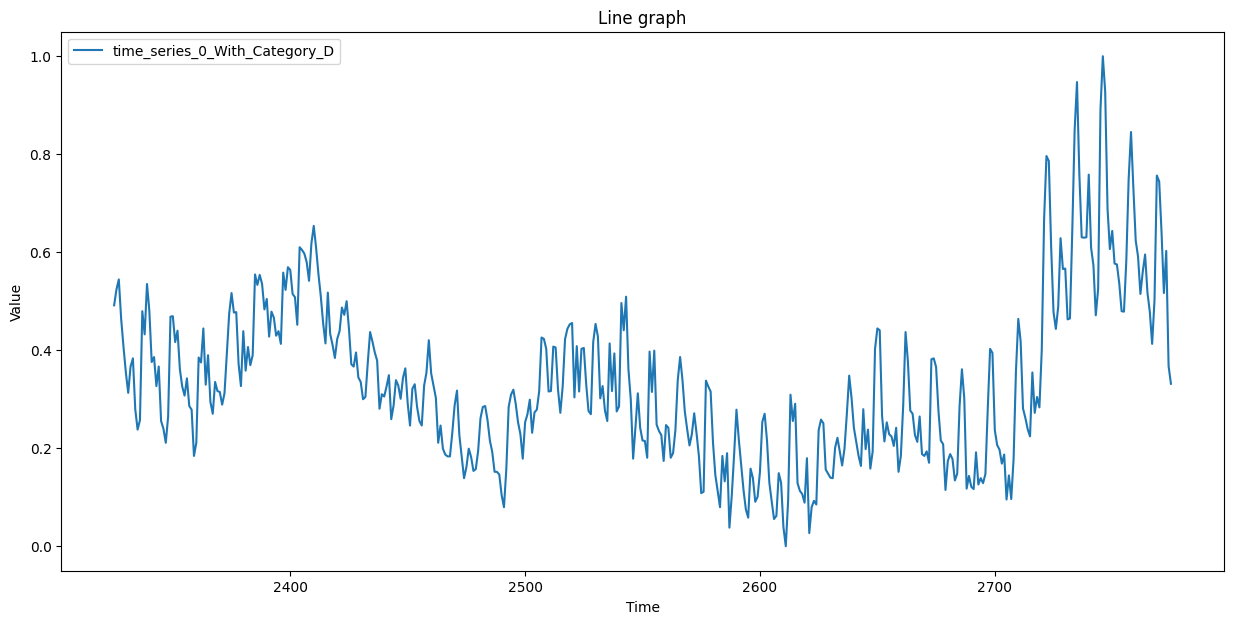

In [9]:
plot_graphs(no_graphs=1,row_start_from=0)

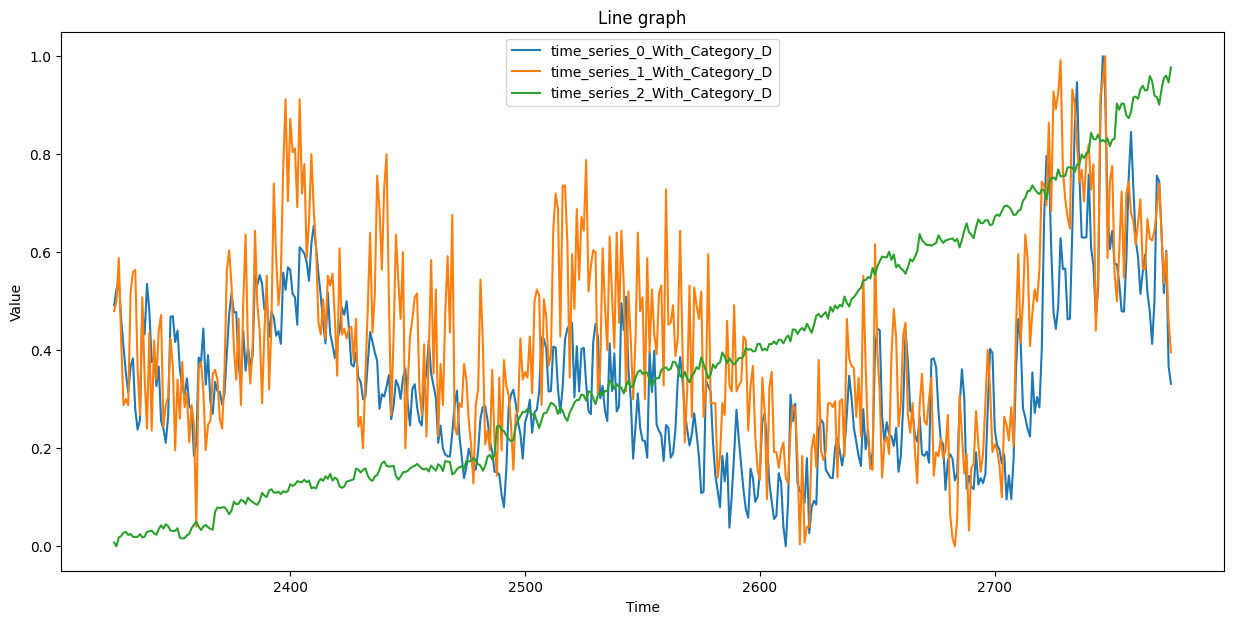

In [10]:
# Another plot for three grpahs
plot_graphs(no_graphs=3,row_start_from=0)

####4-3 Checkoutliers

In [14]:

def checkoutliers ():

  upper_outliers_dict = {}
  lower_outliers_dict = {}
  for row_no in range(training_data_df.shape[0]):

    start_point = valid_periods_df.iloc[row_no,0]
    end_point = valid_periods_df.iloc[row_no,1]
    statistical_info = training_data_df.iloc[row_no,start_point:end_point].describe()
    count = int(statistical_info[0])
    mean =statistical_info[1]
    std = statistical_info[2]
    Q1 = statistical_info[4]
    Q3 = statistical_info[6]

    # Using this rowle for finding outliers
    IQR = Q3-Q1
    lower_bound = Q1 - (1.5*IQR)
    upper_bound = Q3 + (1.5*IQR)

    upper_outliers_index = np.where(training_data_df.iloc[row_no,start_point:end_point]>upper_bound)+start_point
    upper_outliers_index = upper_outliers_index[0]
    upper_outliers = training_data_df.iloc[row_no,upper_outliers_index]

    if upper_outliers.shape[0]>0:
      upper_outliers_dict[f'{row_no}'] = upper_outliers
    else:
      pass

    lower_outliers_index = np.where(training_data_df.iloc[row_no,start_point:end_point]<lower_bound)+start_point
    lower_outliers_index = lower_outliers_index[0]
    lower_outliers = training_data_df.iloc[row_no,lower_outliers_index]

    if lower_outliers.shape[0]>0:
      lower_outliers_dict[f'{row_no}'] = lower_outliers
    else:
      pass

  return upper_outliers_dict, lower_outliers_dict

In [15]:
upper_outliers_dict,lower_outliers_dict = checkoutliers()

###4-4 Plot graphs with outliers

In [16]:
# Plot graphs with outliers
def plot_outliers(row_no_to_show = 84):
  try:

    row_no_to_show = row_no_to_show # chose another number in outliers_dict to see outliers in different rows
    start_point = valid_periods_df.iloc[row_no_to_show,0]
    end_point = valid_periods_df.iloc[row_no_to_show,1]
    data_to_show = training_data_df.iloc[row_no_to_show,start_point:end_point]

    if f'{row_no_to_show}' in upper_outliers_dict:
      upper_outliers = upper_outliers_dict[f'{row_no_to_show}']
    else:
      upper_outliers = None

    if f'{row_no_to_show}' in lower_outliers_dict:
      lower_outliers = lower_outliers_dict[f'{row_no_to_show}']
    else:
      lower_outliers = None

    plot_graphs(no_graphs=1,row_start_from =row_no_to_show,
                show_outliers=True, upper_outliers=upper_outliers,
                lower_outliers=lower_outliers)

    plt.boxplot(x=data_to_show)
    plt.show()

  except:
    print('The row number you entered does not have outliers. Try another one.')
    print('You can chosse from lists below.')
    print(upper_outliers_dict.keys())
    print(f'or {lower_outliers_dict.keys()}')



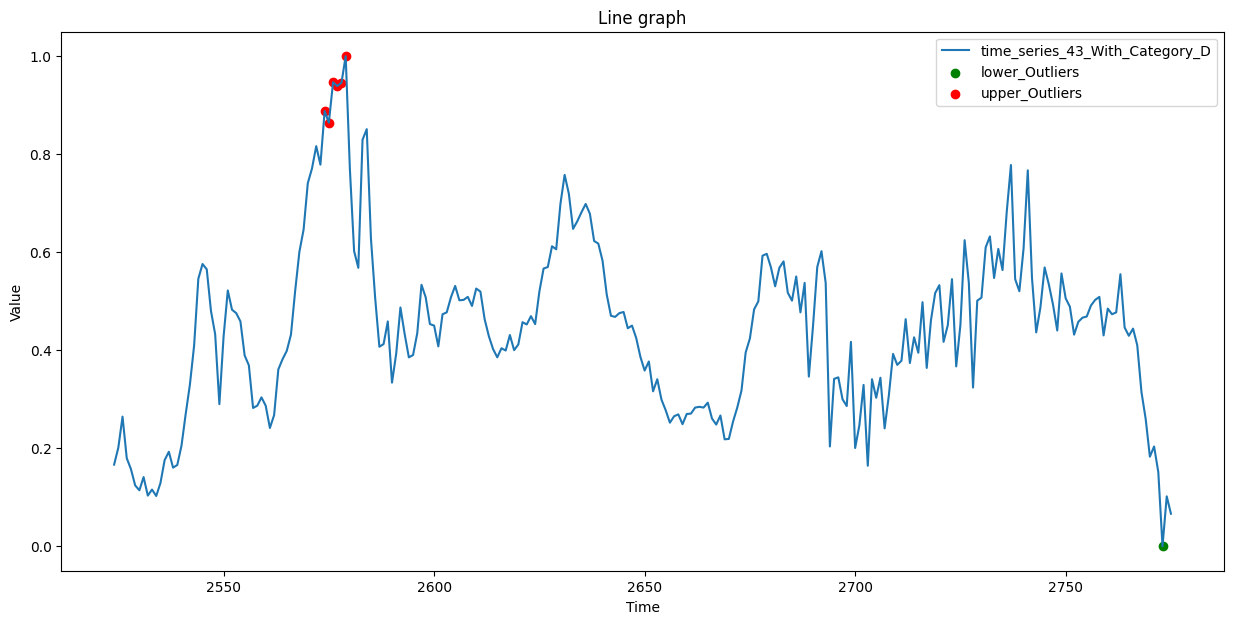

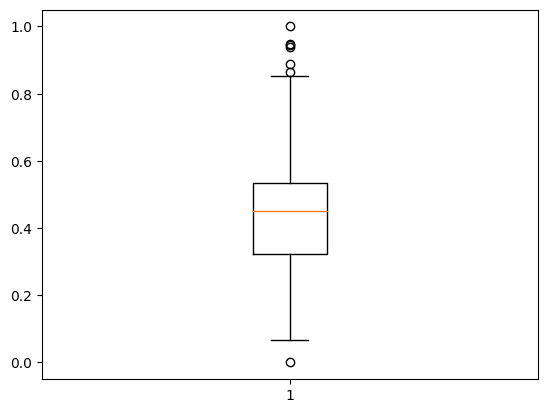

In [19]:
plot_outliers(row_no_to_show=43) # You can change this number to see others

#### 4-5 Replace Outliers with appropriate values.

In [ ]:
# Now, we skip this part to make a model and compare results with outliers and without them.

####4-6 Change dtype for easier computations

In [8]:
training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [9]:
training_data_df = training_data_df.astype(np.float32)
training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.3 MB


###5- Split

In [10]:
# I use simple split.Later, we must change to a better one

test_size = 50
X_train_raw = training_data_df.iloc[:20000,:-test_size]
X_test_raw = training_data_df.iloc[:2000,-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

(20000, 2726) (2000, 50)


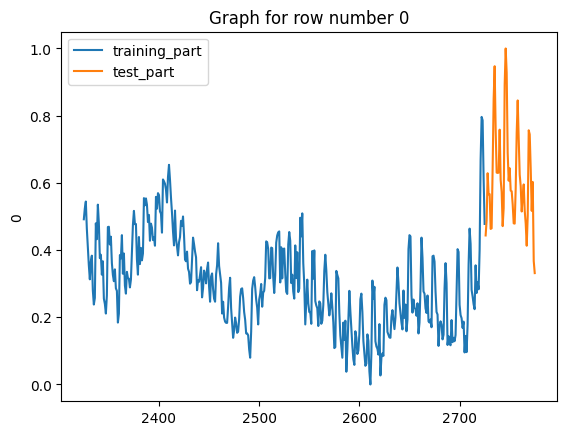

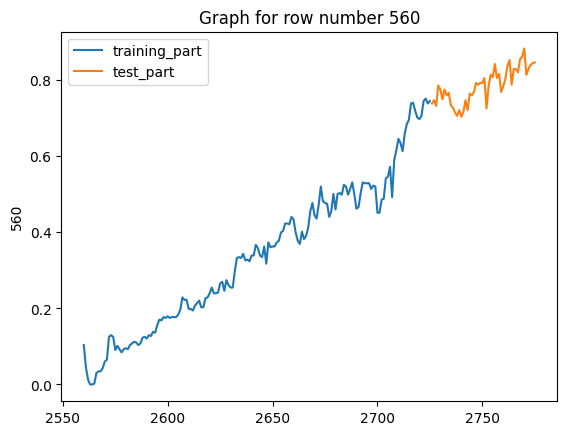

In [11]:
ith_row = 0
start_point = valid_periods_df.iloc[ith_row,0]
end_point = valid_periods_df.iloc[ith_row,1]-test_size
sns.lineplot(x=np.arange(start_point,end_point), y=X_train_raw.iloc[ith_row,start_point:end_point], label='training_part')
sns.lineplot(x=np.arange(end_point,end_point+test_size), y=X_test_raw.iloc[ith_row], label='test_part')
plt.title(f'Graph for row number {ith_row}')
plt.show()

jth_row = 560
start_point = valid_periods_df.iloc[jth_row,0]
end_point = valid_periods_df.iloc[jth_row,1]-test_size
sns.lineplot(x=np.arange(start_point,end_point), y=X_train_raw.iloc[jth_row,start_point:end_point], label='training_part')
sns.lineplot(x=np.arange(end_point,end_point+test_size), y=X_test_raw.iloc[jth_row], label='test_part')
plt.title(f'Graph for row number {jth_row}')
plt.show()

In [36]:
# ##Make transpose
# X_train_raw_t = X_train_raw.transpose()
# X_test_raw_t = X_test_raw.transpose()
# print(X_train_raw_t.shape, X_test_raw_t.shape)

(2726, 48000) (50, 48000)


In [12]:
X_train_raw.shape

(20000, 2726)

In [13]:
def build_sequences(df, window=20, stride=5, telescope=10):

    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df.copy().values

    for idx in np.arange(0,df.shape[1]-window-telescope,stride):
        dataset.append(temp_df[:, idx:idx+window])
        labels.append(temp_label[:, idx:idx+window])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [14]:
target_labels = X_train_raw
window = 20
stride = 5
direct_telescope = 9

In [15]:
X_train, y_train = build_sequences(X_train_raw, window, stride, direct_telescope)
X_test, y_test = build_sequences(X_test_raw, window, stride, direct_telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((540, 20000, 20), (540, 20000, 20), (5, 2000, 20), (5, 2000, 20))

In [16]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200
input_shape

(20000, 20)

In [17]:
output_shape[1]

20

In [18]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [19]:
model = build_CONV_LSTM_model(input_shape, output_shape)
# model.summary()
# tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [20]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
8/8 [==============================] - 28s 2s/step - loss: 3.3005e-04 - val_loss: 0.0294 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - 12s 2s/step - loss: 2.2068e-04 - val_loss: 0.0245 - lr: 0.0010
Epoch 3/200
8/8 [==============================] - 12s 2s/step - loss: 1.7804e-04 - val_loss: 0.0154 - lr: 0.0010
Epoch 4/200
8/8 [==============================] - 13s 2s/step - loss: 1.3808e-04 - val_loss: 0.0119 - lr: 0.0010
Epoch 5/200
8/8 [==============================] - 12s 1s/step - loss: 9.6338e-05 - val_loss: 0.0094 - lr: 0.0010
Epoch 6/200
8/8 [==============================] - 12s 1s/step - loss: 6.1784e-05 - val_loss: 0.0062 - lr: 0.0010
Epoch 7/200
8/8 [==============================] - 12s 2s/step - loss: 3.4950e-05 - val_loss: 0.0052 - lr: 0.0010
Epoch 8/200
8/8 [==============================] - 13s 2s/step - loss: 2.3085e-05 - val_loss: 0.0039 - lr: 0.0010
Epoch 9/200
8/8 [==============================] - 12s 2s/step - loss: 1.8984e-05 - val_

In [21]:
model.save('/content/my_model')

In [34]:
real_test = training_data_df.iloc[500:560,-200:]
real_test.shape

200

In [27]:
def build_sequences1(df, window=20, stride=5, telescope=10):

    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df.copy().values

    for idx in np.arange(0,df.shape[1]-window-telescope,stride):
        dataset.append(temp_df[:, idx:idx+window])
        labels.append(temp_label[:, idx:idx+window])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [31]:
X_test_raw.shape

(2000, 50)

In [26]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (195, 9, 2776)
Mean Squared Error: 0.0030275413300842047
Mean Absolute Error: 0.012051104567945004


In [33]:
!cp -r /content/my_model /content/drive/MyDrive